# **Product Reviews Sentiment Classification**

Our project aims to build a text classification model to predict the sentiment of product reviews scraped from Amazon. The dataset contains reviews of various products, and our objective is to develop a model that can accurately classify these reviews into positive or negative sentiment categories.

To achieve this goal, we will start by checking the distribution of sentiments in the dataset and combine neutral and positive sentiments to create a binary classification task. We will then preprocess the text by removing standard stopwords and punctuations using the NLTK library, and analyze the top frequent words to add a custom stoplist if necessary. We will also convert the text to lowercase, apply stemming and lemmatization, and remove numbers from the review column to prepare the text for modeling.

Next, we will create and visualize a word cloud from the final prepared text to get an idea of the most common words used in the reviews. We will then create two datasets - one vectorized using CountVectorizer and the other using TF-IDF vectorizer - and build logistic regression models on both sets of data. We will compare the performance of these models and choose the one with the best accuracy.

 Through this project, we aim to develop a robust text classification model that can accurately predict the sentiment of product reviews, which could be valuable for businesses in improving their product offerings and customer satisfaction.

## Problem Statement:
This dataset was created from the scraped reviews from products in Amazon for the purpose of text classification. Build a text classification model to predict the sentiment from the review the user writes for the product.


## Load Libraries

In [168]:
import pandas as pd
import requests
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, LancasterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from wordcloud import WordCloud, STOPWORDS
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

%matplotlib inline

## Reading data

In [169]:
# The URL of the file to download
url = 'https://drive.google.com/uc?id=1ovYnpXHUVHln4NuSo9IcY0Db1fAIu-RN'

# Send a GET request to the URL to download the file
response = requests.get(url)

# Save the downloaded file to disk
with open('data.csv', 'wb') as f:
    f.write(response.content)

# Read the data from the downloaded file using pandas
data = pd.read_csv('data.csv')



## EDA

In [170]:
# Check the shape of teh data
data.shape

(17340, 4)

In [171]:
# check columns in the dataset
data.columns

Index(['sentiments', 'cleaned_review', 'cleaned_review_length',
       'review_score'],
      dtype='object')

In [172]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17340 entries, 0 to 17339
Data columns (total 4 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   sentiments             17340 non-null  object 
 1   cleaned_review         17337 non-null  object 
 2   cleaned_review_length  17340 non-null  int64  
 3   review_score           17340 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 542.0+ KB


In [173]:
data.head(n=5)

,sentiments,cleaned_review,cleaned_review_length,review_score
0,positive,i wish would have gotten one earlier love it a...,19,5.0
1,neutral,i ve learned this lesson again open the packag...,88,1.0
2,neutral,it is so slow and lags find better option,9,2.0
3,neutral,roller ball stopped working within months of m...,12,1.0
4,neutral,i like the color and size but it few days out ...,21,1.0


## Checking Null values:

In [174]:
data.isnull().sum()

sentiments               0
cleaned_review           3
cleaned_review_length    0
review_score             0
dtype: int64

### Droppingt missing cases

In [175]:
data = data.dropna()

In [176]:
# check summary statistics of numeric columns
data.describe()

,cleaned_review_length,review_score
count,17337.000000,17337.000000
mean,30.305705,3.648901
std,35.837424,1.673580
min,0.000000,1.000000
25%,9.000000,2.000000
50%,20.000000,5.000000
75%,38.000000,5.000000
max,571.000000,5.000000


In [177]:
# check the distribution  of sentiments
data['sentiments'].value_counts()

positive    9503
neutral     6300
negative    1534
Name: sentiments, dtype: int64

### Visualization of sentiment and review score

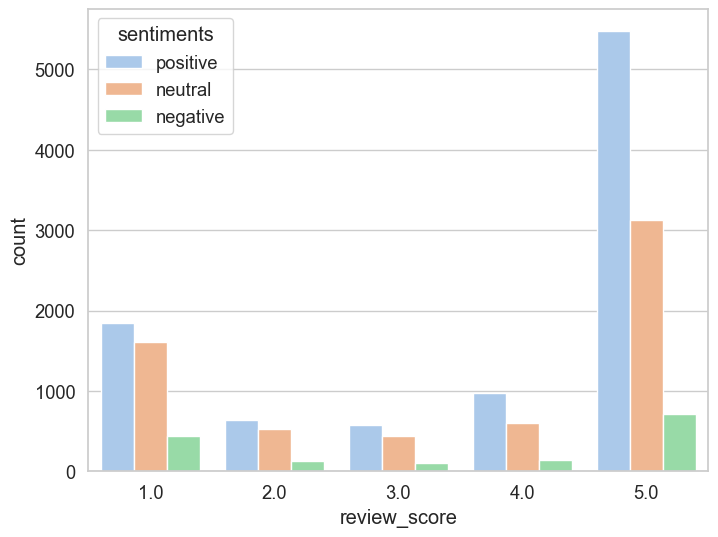

In [178]:
sns.set(rc={'figure.figsize':(8,6)})
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.2)
sns.set_palette("pastel")
sns.countplot(x="review_score", data=data, hue='sentiments')
plt.show()

### Distribution of Cleaned Review Length by Sentiment

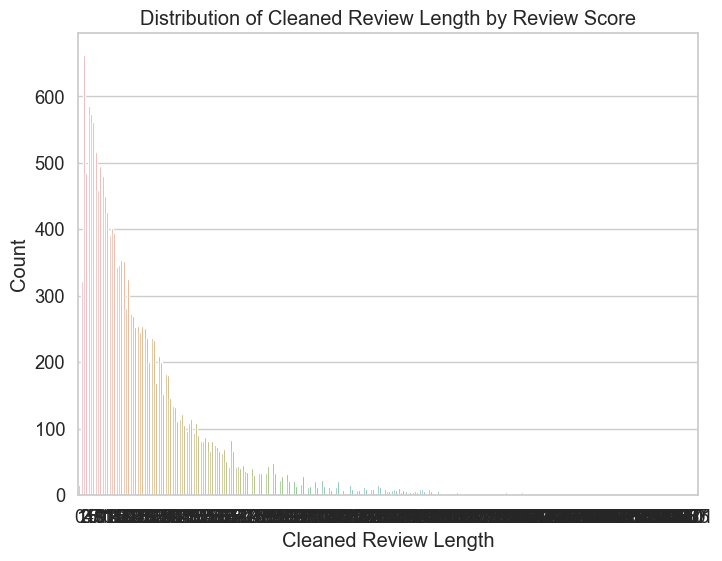

In [179]:
# set figure size and adjust bar spacing
sns.set(rc={'figure.figsize':(8,6)})
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.2)
sns.set_palette("pastel")
sns.countplot(x='cleaned_review_length', data=data, dodge=True) #, hue= 'sentiments')

# add axis labels and title
plt.xlabel('Cleaned Review Length')
plt.ylabel('Count')
plt.title('Distribution of Cleaned Review Length by Review Score')

# display the plot
plt.show()

## Task1: Check the distribution of Sentiments. 

### Then combine the neutral & positive as Positive thereby making this data suitable for binary classification task.

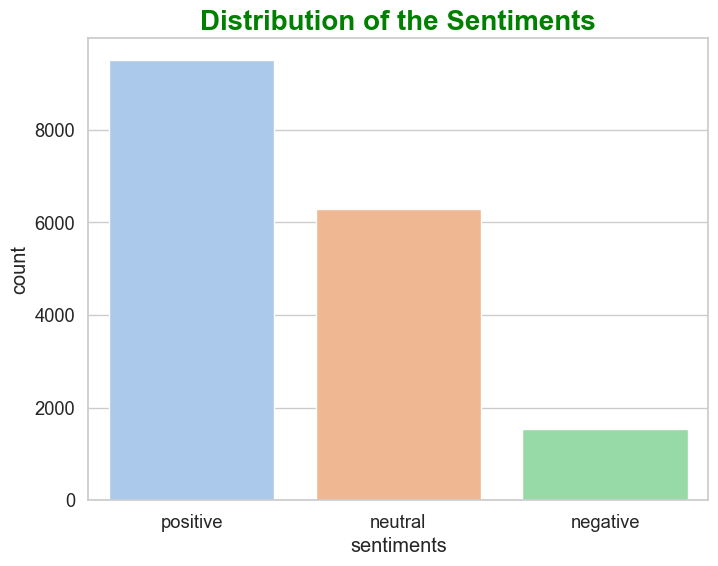

In [180]:
# Plot a bar chart of the sentiment counts using seaborn
sns.countplot(x='sentiments', data=data)
# Set the title of the chart
plt.title('Distribution of the Sentiments', fontdict={'size': 20, 'weight': 'bold', 'color': 'green'})
# Show the chart
plt.show()

In [181]:
# Lets create a clean data set and then wrangle the data to combine neutral and positive into positive
data_clean=data
# combine neutral and positive into positive
data_clean['sentiments'] = data_clean['sentiments'].apply(lambda x: 'Positive' if x in ['neutral', 'positive'] else 'Negative')

# print the new value counts
print(data_clean['sentiments'].value_counts())

Positive    15803
Negative     1534
Name: sentiments, dtype: int64


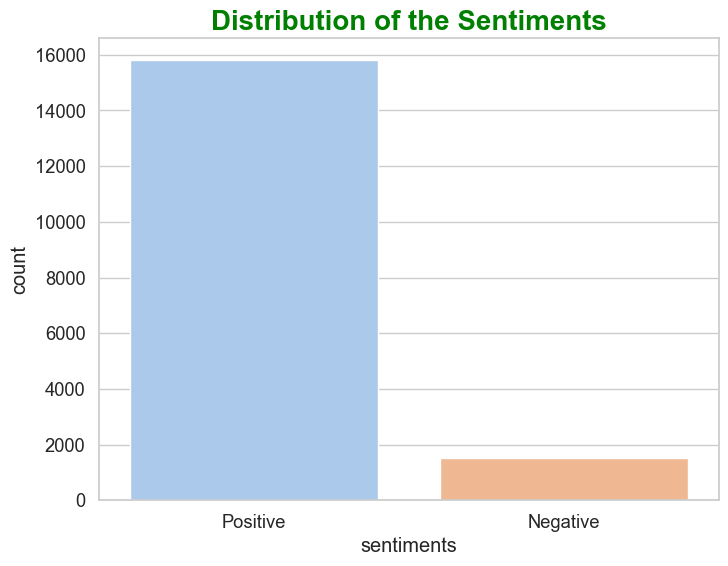

In [182]:
# Plot a bar chart of the sentiment counts using seaborn using the cleam dataset
sns.countplot(x='sentiments', data=data_clean)
# Set the title of the chart
plt.title('Distribution of the Sentiments', fontdict={'size': 20, 'weight': 'bold', 'color': 'green'})
# Show the chart
plt.show()

##  Task 2. Remove standard stopwords and punctuations from the text using NLTK library. 
Then get the top frequent words in the text and analyze it to add a custom stoplist if a word has high frequency but not enough meaning to identify emotions.

### Tokenization

In [183]:
# download wordnet stopwords and punkt from NLTK
import nltk
nltk.download('wordnet','punkt','stopwords')


True

### Tokenization

In [184]:
data_clean_final=data_clean[['sentiments','cleaned_review']]
data_clean_final.head()

,sentiments,cleaned_review
0,Positive,i wish would have gotten one earlier love it a...
1,Positive,i ve learned this lesson again open the packag...
2,Positive,it is so slow and lags find better option
3,Positive,roller ball stopped working within months of m...
4,Positive,i like the color and size but it few days out ...


In [185]:
data_clean_final.loc[3,'cleaned_review']

'roller ball stopped working within months of minimal use piece of junk '

In [186]:
sent_tokenize(data_clean_final.loc[13,'cleaned_review'])

['i liked the wireless mouse however after months the roller on the mouse stopped working which leaves me not being able to scroll up or down on my pc ll have to look into buying more sturdy mouse']

In [187]:
word_tokenize(data_clean_final.loc[13,'cleaned_review'])

['i',
 'liked',
 'the',
 'wireless',
 'mouse',
 'however',
 'after',
 'months',
 'the',
 'roller',
 'on',
 'the',
 'mouse',
 'stopped',
 'working',
 'which',
 'leaves',
 'me',
 'not',
 'being',
 'able',
 'to',
 'scroll',
 'up',
 'or',
 'down',
 'on',
 'my',
 'pc',
 'll',
 'have',
 'to',
 'look',
 'into',
 'buying',
 'more',
 'sturdy',
 'mouse']

## Task 3. Convert the text to lowercase, apply stemming, lemmatization, and remove numbers from the review column.

### Converting text to lowercae

In [188]:
# convert text to lower case
reviews=list(data_clean_final['cleaned_review'])
len(reviews)

17337

In [189]:
reviews[2533]

'i got this for my daughter for school it is perfect and appeals to her teenage likes'

In [190]:
reviews[2533].lower()

'i got this for my daughter for school it is perfect and appeals to her teenage likes'

In [191]:
reviews_lower = []
for review in reviews:
    if isinstance(review, str):
        reviews_lower.append(review.lower())
    else:
        reviews_lower.append(str(review).lower())





In [192]:
tokens =[word_tokenize(r) for r in reviews_lower]

In [193]:
tokens[1344]

['i',
 'like',
 'the',
 'feel',
 'and',
 'look',
 'of',
 'this',
 'mouse',
 'bought',
 'it',
 'as',
 'deal',
 'of',
 'the',
 'day',
 'really',
 'like',
 'how',
 'it',
 'changes',
 'colors',
 'and',
 'how',
 'smooth',
 'it',
 'feels',
 'also',
 'love',
 'that',
 'you',
 'can',
 'recharge',
 'it',
 'only',
 'dislike',
 'is',
 'that',
 'review',
 'and',
 'edit',
 'important',
 'documents',
 'for',
 'work',
 'and',
 'sometimes',
 'the',
 'cursor',
 'would',
 'move',
 'unexpectedly',
 'and',
 'will',
 'cause',
 'me',
 'to',
 'type',
 'something',
 'wasn',
 'trying',
 'to',
 'type',
 'll',
 'have',
 'to',
 'undo',
 'whatever',
 'did',
 'other',
 'than',
 'that',
 'good',
 'price',
 'and',
 'quality']

### Stopword removals

In [194]:
sw = stopwords.words('english')

In [195]:
## Looping a list of tokens  sublist
tokens = [[word for word in t if word not in sw] for t in tokens]

In [196]:
tokens[1344]

['like',
 'feel',
 'look',
 'mouse',
 'bought',
 'deal',
 'day',
 'really',
 'like',
 'changes',
 'colors',
 'smooth',
 'feels',
 'also',
 'love',
 'recharge',
 'dislike',
 'review',
 'edit',
 'important',
 'documents',
 'work',
 'sometimes',
 'cursor',
 'would',
 'move',
 'unexpectedly',
 'cause',
 'type',
 'something',
 'trying',
 'type',
 'undo',
 'whatever',
 'good',
 'price',
 'quality']

In [197]:
reviews[1344]

'i like the feel and look of this mouse bought it as deal of the day really like how it changes colors and how smooth it feels also love that you can recharge it only dislike is that review and edit important documents for work and sometimes the cursor would move unexpectedly and will cause me to type something wasn trying to type ll have to undo whatever did other than that good price and quality '

### Remove punctuation marks

In [198]:
tokenizer = RegexpTokenizer(r'\w+')

In [199]:
tokens= [[" ".join(tokenizer.tokenize(word)) for word in t if len(tokenizer.tokenize(word))>0] for t in tokens]

In [200]:
tokens[1344]

['like',
 'feel',
 'look',
 'mouse',
 'bought',
 'deal',
 'day',
 'really',
 'like',
 'changes',
 'colors',
 'smooth',
 'feels',
 'also',
 'love',
 'recharge',
 'dislike',
 'review',
 'edit',
 'important',
 'documents',
 'work',
 'sometimes',
 'cursor',
 'would',
 'move',
 'unexpectedly',
 'cause',
 'type',
 'something',
 'trying',
 'type',
 'undo',
 'whatever',
 'good',
 'price',
 'quality']

In [201]:
reviews[1344]

'i like the feel and look of this mouse bought it as deal of the day really like how it changes colors and how smooth it feels also love that you can recharge it only dislike is that review and edit important documents for work and sometimes the cursor would move unexpectedly and will cause me to type something wasn trying to type ll have to undo whatever did other than that good price and quality '

### Stemming

In [202]:
porter=PorterStemmer()
lancanster =LancasterStemmer()


In [203]:
tokens = [[ porter.stem(word)for word in t] for t in tokens]

In [204]:
tokens[1344]

['like',
 'feel',
 'look',
 'mous',
 'bought',
 'deal',
 'day',
 'realli',
 'like',
 'chang',
 'color',
 'smooth',
 'feel',
 'also',
 'love',
 'recharg',
 'dislik',
 'review',
 'edit',
 'import',
 'document',
 'work',
 'sometim',
 'cursor',
 'would',
 'move',
 'unexpectedli',
 'caus',
 'type',
 'someth',
 'tri',
 'type',
 'undo',
 'whatev',
 'good',
 'price',
 'qualiti']

In [205]:
tokens[1344]

['like',
 'feel',
 'look',
 'mous',
 'bought',
 'deal',
 'day',
 'realli',
 'like',
 'chang',
 'color',
 'smooth',
 'feel',
 'also',
 'love',
 'recharg',
 'dislik',
 'review',
 'edit',
 'import',
 'document',
 'work',
 'sometim',
 'cursor',
 'would',
 'move',
 'unexpectedli',
 'caus',
 'type',
 'someth',
 'tri',
 'type',
 'undo',
 'whatev',
 'good',
 'price',
 'qualiti']

## Task 4.	Create and visualize a word cloud from the final prepared text. 

### Word count ditribution

In [206]:
tokens[10:15]

[['beauti',
  'produc',
  'love',
  'look',
  'mous',
  'light',
  'welcom',
  'addit',
  'otherwis',
  'drab',
  'workspac',
  'notic',
  'tend',
  'go',
  'sleep',
  'mode',
  'quickli',
  'take',
  'longer',
  'wake',
  'time',
  'expect',
  'screen',
  'busi',
  'window',
  'cursor',
  'freez',
  'posit',
  'mous',
  'fulli',
  'come',
  'back',
  'life',
  'frustrat',
  'anyon',
  'patient'],
 ['first',
  'one',
  'broke',
  'week',
  'sent',
  'replac',
  'return',
  'broken',
  'one',
  'still',
  'process',
  'return',
  'new',
  'one',
  'broke',
  'week',
  'later',
  'would',
  'recommend',
  'mous'],
 ['typic',
  'write',
  'review',
  'keep',
  'issu',
  'tech',
  'product',
  'amazon',
  'mous',
  'stop',
  'work',
  'month',
  'use',
  'charg',
  'sometim',
  'get',
  'short',
  'term',
  'use',
  'glitchi',
  'lag',
  'across',
  'screen'],
 ['like',
  'wireless',
  'mous',
  'howev',
  'month',
  'roller',
  'mous',
  'stop',
  'work',
  'leav',
  'abl',
  'scroll',
  

In [207]:
flat_tokens= [word for t in tokens for word in t]

In [208]:
len(flat_tokens)

271695

In [209]:
flat_tokens[:10]

['wish',
 'would',
 'gotten',
 'one',
 'earlier',
 'love',
 'make',
 'work',
 'laptop',
 'much']

In [210]:
counts=Counter(flat_tokens)

In [211]:
len(counts)

6429

In [212]:
counts.most_common(10)

[('work', 7481),
 ('mous', 6586),
 ('use', 5664),
 ('great', 4608),
 ('charg', 4214),
 ('sound', 3586),
 ('love', 3333),
 ('good', 2985),
 ('like', 2879),
 ('light', 2842)]

### Bag of words

In [213]:
clean_reviews = [" ".join(t) for t in tokens]

In [214]:
clean_reviews[1344]

'like feel look mous bought deal day realli like chang color smooth feel also love recharg dislik review edit import document work sometim cursor would move unexpectedli caus type someth tri type undo whatev good price qualiti'

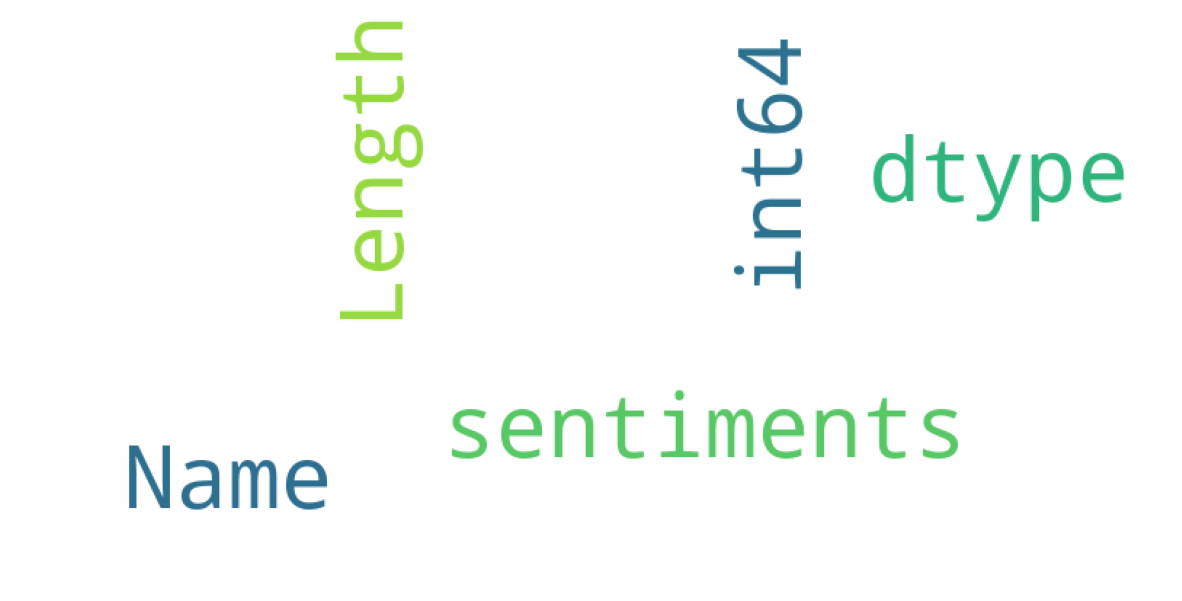

In [240]:
from wordcloud import WordCloud, STOPWORDS

stopwords = set(STOPWORDS)

def wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=250,
        max_font_size=30,
        scale=2,
        random_state=5 #chosen a andom by flipping a coin; it was heads
    ).generate(str(data))

    fig = plt.figure(1, figsize=(15, 15))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)
    plt.imshow(wordcloud)
    plt.show()

wordcloud(data_clean_final['sentiments'])


## Task 5.	Create two datasets - one vectorized using countvectorizer and other using tf-idf vectorizer

## Count Vectorizer

In [216]:
vect= CountVectorizer(min_df= 5)

In [217]:
X=vect.fit_transform(clean_reviews)

In [218]:
X.shape

(17337, 2369)

#### Unique words in the Vocabulary

In [219]:
vect.vocabulary_

{'wish': 2316,
 'would': 2339,
 'gotten': 891,
 'one': 1391,
 'earlier': 623,
 'love': 1194,
 'make': 1214,
 'work': 2327,
 'laptop': 1118,
 'much': 1306,
 'easier': 630,
 'learn': 1135,
 'lesson': 1146,
 'open': 1395,
 'packag': 1426,
 'use': 2227,
 'product': 1556,
 'right': 1701,
 'away': 139,
 'order': 1403,
 'mous': 1299,
 'august': 128,
 'travel': 2149,
 'pack': 1425,
 'bag': 154,
 'famili': 734,
 'sinc': 1836,
 'mid': 1260,
 'septemb': 1778,
 'took': 2124,
 'charg': 326,
 'fine': 766,
 'coupl': 457,
 'week': 2282,
 'recharg': 1631,
 'day': 504,
 'two': 2175,
 'ceas': 312,
 'function': 841,
 'optic': 1401,
 'light': 1155,
 'flash': 783,
 'turn': 2169,
 'noth': 1362,
 'cours': 459,
 'return': 1692,
 'window': 2309,
 'well': 2288,
 'past': 1450,
 'slow': 1858,
 'lag': 1111,
 'find': 765,
 'better': 196,
 'option': 1402,
 'roller': 1713,
 'ball': 156,
 'stop': 1961,
 'within': 2317,
 'month': 1292,
 'minim': 1271,
 'piec': 1480,
 'junk': 1084,
 'like': 1160,
 'color': 383,
 'size': 

In [220]:
len(vect.vocabulary_)

2369

### Convert sparse matrix  to an array

In [221]:
#Lets check the type of X
type(X)

scipy.sparse._csr.csr_matrix

In [222]:
# Lets convert to array
X_a = X.toarray()

In [223]:
X_a.shape

(17337, 2369)

In [224]:
X_a[1344,:]

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [225]:
data_clean_final.head()

,sentiments,cleaned_review
0,Positive,i wish would have gotten one earlier love it a...
1,Positive,i ve learned this lesson again open the packag...
2,Positive,it is so slow and lags find better option
3,Positive,roller ball stopped working within months of m...
4,Positive,i like the color and size but it few days out ...


In [226]:
data_clean_final = data_clean_final.copy()
data_clean_final.loc[:, "sentiments"] = data_clean_final["sentiments"].apply(lambda x: 1 if x=="Positive" else 0)


C:\Users\keyeg\AppData\Local\Temp\ipykernel_9876\1320386751.py:2: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data_clean_final.loc[:, "sentiments"] = data_clean_final["sentiments"].apply(lambda x: 1 if x=="Positive" else 0)


In [227]:
y = data_clean_final["sentiments"]

In [228]:
print(X.shape)
print(y.shape)


(17337, 2369)
(17337,)


### Split the dataset into train and test

In [229]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42, shuffle=True)


### Build a Logistic Regression model

In [230]:
model = LogisticRegression()

In [231]:
model.fit(X_train, y_train)

c:\Users\keyeg\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [232]:
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)
print(f"Train Accuracy:{accuracy_score(y_train, train_pred)}")
print(f"Test Accuracy:{accuracy_score(y_test, test_pred)}")

Train Accuracy:0.9717355252721898
Test Accuracy:0.9420415224913494


## TF-IDF

In [233]:
vect=TfidfVectorizer(min_df=5)

In [234]:
X=vect.fit_transform(clean_reviews)

In [235]:
X.shape

(17337, 2369)

In [236]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                   stratify=y, random_state=42)

In [237]:
model=LogisticRegression()
model.fit(X_train,y_train)

LogisticRegression()

In [238]:
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)
print(f"Train Accuracy:{accuracy_score(y_train, train_pred)}")
print(f"Test Accuracy:{accuracy_score(y_test, test_pred)}")

Train Accuracy:0.9353233830845771
Test Accuracy:0.9273356401384083


In [239]:
import pickle

with open("count_vect.pk", "wb") as f:
    pickle.dump(vect, f)
    
with open("count_vect_lr.pkl", "wb") as f:
    pickle.dump(model, f)


## Conclusion

We have built a text classification model to predict the sentiment of product reviews scraped from Amazon. We started by preprocessing the text data by removing stopwords and punctuations, analyzing the top frequent words, and converting the text to lowercase while removing numbers.

We created a binary classification task by combining neutral and positive sentiments, and then we visualized a word cloud from the final prepared text to get an idea of the most common words used in the reviews. We then created two datasets using CountVectorizer and TF-IDF vectorizer and built logistic regression models on both sets of data.

We compared the performance of these models by evaluating the train and test accuracies. Our CountVectorizer model achieved higher accuracy than the TF-IDF model, with a Train Accuracy of 0.9717 and a Test Accuracy of 0.9420. The TF-IDF model had a Train Accuracy of 0.9353 and a Test Accuracy of 0.9273.

Overall, our text classification model demonstrated a high level of accuracy in predicting the sentiment of product reviews, which could be valuable for businesses to improve their product offerings and customer satisfaction. By using different vectorization techniques and comparing their performance, we gained insights into the strengths and weaknesses of these approaches and can use this knowledge to choose the best model for future text classification tasks.

In [241]:
*.pyc
.vscode/


SyntaxError: invalid syntax (55321007.py, line 1)